# TestCase 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from create_jsonfile import ask_user,read_config,check_config

# ask_user()
config = read_config(configfile="configs/config1.json")

### Configuration has been read from config.json ###
# dimension : 1
# testcase : 1
# version : 1
# error_estimations : {'param_num': 1}
# gains : {'n_params': 100}


In [3]:
dimension = config["dimension"]
testcase = config["testcase"]
version = config["version"]   
# high_degree = 10

In [4]:
assert testcase == 1
check_config(config)

Config file is valid


## Imports + Load network

In [5]:
# export CUDA_VISIBLE_DEVICES=
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
from IPython.display import Math, display

In [6]:
from testcases.utils import create_tree

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
current_dir = os.getcwd()
repo_dir = os.path.dirname(current_dir)
repo_dir = os.path.dirname(repo_dir)
print(repo_dir)
# vérifier que repo_dir finit bien par "code" (à modifier pour l'utilisateur)
assert repo_dir.split("/")[-1] == "code"

/home/flecourtier/Bureau/Article1/code


In [8]:
if version == 1:
    from testcases.networks.test_1D.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from testcases.networks.test_1D.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
else:
    raise ValueError("Version not found")
from testcases.problem.problem_1D import TestCase1
problem = TestCase1(version=version)

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


/home/flecourtier/Bureau/Article1/code
torch loaded; device is cuda


init
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1.pth
network loaded
Error  tensor([0.0434])


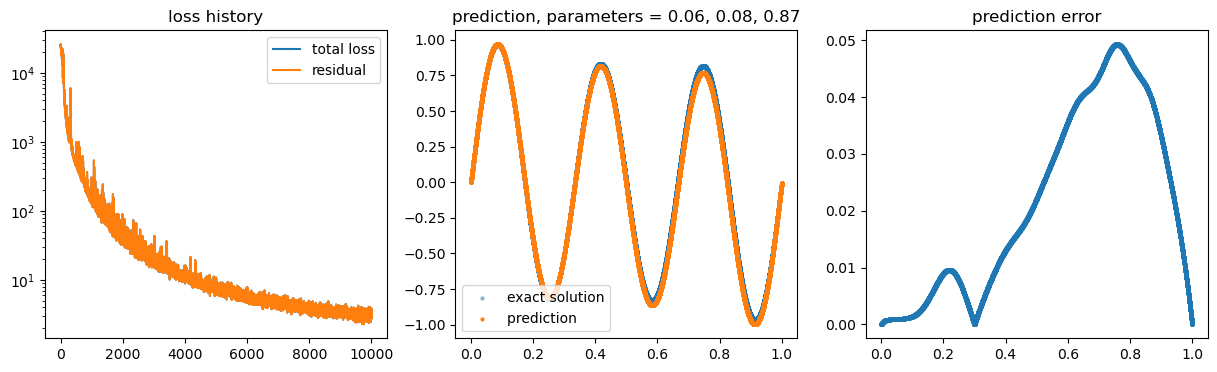

In [9]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

## Error estimations

### Imports

In [10]:
from modfenics.error_estimations.error_estimations import ErrorEstimations
from modfenics.error_estimations.compare import CompareMethods

In [11]:
param_num = config["error_estimations"]["param_num"]     
error_estimations = ErrorEstimations(param_num, problem, repo_dir = repo_dir, tab_degree=[1])
compare_methods = CompareMethods(error_estimations)
tab_nb_vert = error_estimations.tab_nb_vert

## Results directory: /home/flecourtier/Bureau/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param1/


### Run FEM

In [12]:
degree = 1
df_FEM, tab_h_FEM, tab_err_FEM = error_estimations.run_fem_deg(degree,new_run=False)

## Read csv file : /home/flecourtier/Bureau/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param1/FEM_case1_v1_param1_degree1.csv


In [13]:
# error_estimations.run_fem_alldeg(new_run=False,plot_cvg=False)

### Run Add

In [14]:
degree = 1
df_Corr, tab_h_Corr, tab_err_Corr = error_estimations.run_corr_deg(degree,u_theta,new_run=False)

## Read csv file : /home/flecourtier/Bureau/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param1/Corr_case1_v1_param1_degree1.csv


In [53]:
# error_estimations.run_corr_alldeg(u_theta,new_run=False,plot_cvg=False)

### Run Mult

In [16]:
tab_M = [3.0,100.0]

In [17]:
degree = 1
error_estimations.run_mult_deg_allM(degree,u_theta,tab_M,new_run=False)

## Read csv file : /home/flecourtier/Bureau/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param1/Mult_case1_v1_param1_degree1_M3.0.csv
## Read csv file : /home/flecourtier/Bureau/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param1/Mult_case1_v1_param1_degree1_M100.0.csv


In [18]:
# error_estimations.run_mult_alldeg_allM(u_theta,tab_M,new_run=False,plot_cvg=False)

### Save results

/home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/cvg/param1/Mult_case1_v2_param1_degree1_M3.0.csv
Mult weak P1 M3.0 not found
/home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/cvg/param1/Mult_case1_v2_param1_degree1_M100.0.csv
Mult weak P1 M100.0 not found


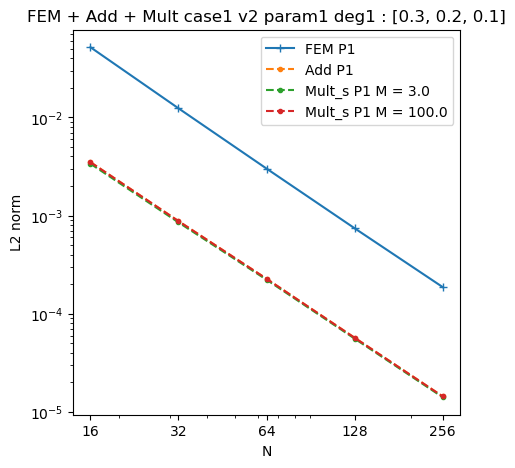

In [19]:
compare_methods.plot_Mult_vs_Add_vs_FEM_alldeg_allM(tab_M)

In [20]:
compare_methods.save_tab_alldeg_allM(tab_M)

Mult weak P1 M3.0 not found
Mult weak P1 M100.0 not found


/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:189: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')


## Gains constant from Error estimations

In [25]:
deg_m = 0
assert deg_m in [0,1]

In [26]:
import numpy as np
from scimba.equations.domain import SpaceTensor
from testcases.utils import select_param
import dolfin as df
import math

N_ex = 500
mesh_ex = df.UnitIntervalMesh(N_ex)
V_ex = df.FunctionSpace(mesh_ex, "CG", 4)
dx_ex = df.Measure("dx", domain=mesh_ex)
XXYY = V_ex.tabulate_dof_coordinates().reshape(-1,1)

param_num = config["error_estimations"]["param_num"]    
params = [select_param(problem,param_num)]

X_test = torch.tensor(XXYY,requires_grad=True)
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

# get parameters
nb_params = len(trainer.pde.parameter_domain)
shape = (XXYY.shape[0],nb_params)
ones = torch.ones(shape)
mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)

u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()[:,0]
du_ex_dx = pde.reference_solution_derivative(X_test, mu_test).cpu().detach().numpy()[:,0]
d2u_ex_dx2 = pde.reference_solution_second_derivative(X_test, mu_test).cpu().detach().numpy()[:,0]

pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
        
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()

In [27]:
# Solutions
u_fe = df.Function(V_ex)
u_fe.vector()[:] = u_ex

u_theta_fe = df.Function(V_ex)
u_theta_fe.vector()[:] = u_theta_

# First derivatives
dudx_fe = df.Function(V_ex)
dudx_fe.vector()[:] = du_ex_dx

duthetadx_fe = df.Function(V_ex)
duthetadx_fe.vector()[:] = u_theta_x

# Second derivatives
d2udx2_fe = df.Function(V_ex)
d2udx2_fe.vector()[:] = d2u_ex_dx2

d2uthetadx2_fe = df.Function(V_ex)
d2uthetadx2_fe.vector()[:] = u_theta_xx

### Add

$$C_\text{\rm gain}^+= \frac{| u-u_{\theta} |_{H^{q+1}}}{| u |_{H^{q+1}}}$$

In [28]:
seminormH2 = df.assemble((((d2udx2_fe - d2uthetadx2_fe)) ** 2) * dx_ex) ** (0.5)
seminormH2_rel = df.assemble(d2udx2_fe ** 2 * dx_ex) ** (0.5)
c_gain_add = seminormH2 / seminormH2_rel
coeff = math.factorial(deg_m) / math.factorial(deg_m//2)**2
cvg = coeff * c_gain_add

display(Math(r"$m = " + f"{deg_m}$" + r" ; $\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2} = " + f"{coeff}$"))
display(Math(r"$C_\text{gain}^+ = " + f"{c_gain_add}$"))
display(Math(r"$\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}C_\text{gain}^+ = " + f"{cvg}$"))
display(Math(r"$1/C_\text{gain}^+ = " + f"{1/c_gain_add}$"))
display(Math(r"$\frac{1}{\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}C_\text{gain}^+} = " + f"{1/cvg}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Mult

$$C_\text{\rm gain}^\times(M) = \frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}
    \left| \frac{u_M}{u_{\theta,M}} \right|_{H^{q+1}}
    \frac{\| u_{\theta,M}\|_{W^{m,\infty}}}{| u |_{H^{q+1}}}$$

In [29]:
tab_M = [i for i in range(3,100001)]

In [30]:
u_fe_M = df.Function(V_ex)
u_theta_fe_M = df.Function(V_ex)

tab_c_gain_mult = []
for M in tab_M:
    # print("M = ",M)
    u_fe_M.vector()[:] = u_ex+M
    u_theta_fe_M.vector()[:] = u_theta_+M

    num = df.Function(V_ex)
    den = df.Function(V_ex)
    num.vector()[:] = u_theta_fe_M.vector()[:]**2 * d2udx2_fe.vector()[:] - 2 * u_theta_fe_M.vector()[:] * duthetadx_fe.vector()[:] * dudx_fe.vector()[:] - u_fe_M.vector()[:] * (u_theta_fe_M.vector()[:]*d2uthetadx2_fe.vector()[:] - 2 * duthetadx_fe.vector()[:]**2)
    den.vector()[:] = u_theta_fe_M.vector()[:]**3

    seminormH2 = df.assemble((num/den)**2 * dx_ex) ** (0.5)
    seminormH2_rel = df.assemble(d2udx2_fe ** 2 * dx_ex) ** (0.5)
    
    assert deg_m in [0,1], "deg_m must be 0 or 1"
    if deg_m == 0:
        norm_Linf = np.max(np.abs(u_theta_fe_M.vector()[:]))
    else:
        uthetaLinfty = np.max(np.abs(u_theta_fe_M.vector()[:]))
        graduthetaLinfty = np.max(np.abs(duthetadx_fe.vector()[:]))
        norm_Linf = uthetaLinfty + graduthetaLinfty
    
    c_gain_mult = seminormH2 / seminormH2_rel * norm_Linf * coeff
    tab_c_gain_mult.append(c_gain_mult)
tab_c_gain_mult = np.array(tab_c_gain_mult)


# display(Math(r"$C_\text{gain}^\times = " + f"{list(tab_c_gain_mult)}$"))
# display(Math(r"$1/C_\text{gain}^\times = " + f"{list(1/tab_c_gain_mult)}$"))

### Add vs Mult

$$C^{\times}_{\text{\rm gain}}(M)
        \underset{M\rightarrow\infty}{\longrightarrow}
        \frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}C^{+}_{\text{\rm gain}}$$

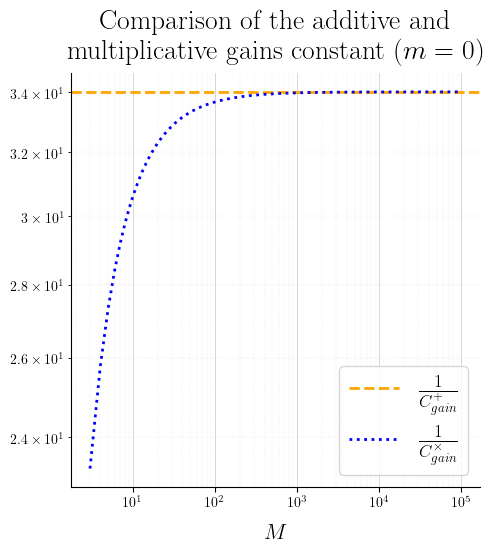

In [31]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Configuration des polices LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Taille des textes pour les titres, axes, etc.
title_size = 20
legend_size = 16

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(5, 5))

# Tracés des courbes
ax.axhline(y=1.0/cvg, color="orange", linestyle='--', linewidth=2, label=r"$\frac{1}{C_{gain}^+}$")
ax.loglog(tab_M, 1.0/tab_c_gain_mult, linestyle='dotted', linewidth=2, color="blue", label=r"$\frac{1}{C_{gain}^\times}$")

# Configurer les axes
ax.set_xlabel(r"$M$", fontsize=legend_size, labelpad=10)

# Configurer les ticks principaux (uniquement) pour l'axe x
# ax.set_xticks(tab_M)
# ax.set_xticklabels(labels=tab_M, fontsize=legend_size-2)
ax.tick_params(axis='x', which='minor', bottom=False, labelsize=legend_size-2)

# Configurer les ticks principaux (uniquement) pour l'axe y
ax.tick_params(axis='y', labelsize=legend_size - 2)

# Ajouter une grille légère
ax.grid(visible=True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.3, alpha=0.5)

# Supprimer les bordures supérieures et droites
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajuster la légende
ax.legend(fontsize=legend_size+2)

# Ajustement des marges
plt.tight_layout()
plt.title(f"Comparison of the additive and\nmultiplicative gains constant ($m={deg_m}$)", fontsize=title_size,pad = 10) 

# Afficher
plt.savefig(f"comp_mult_add_gain_m{deg_m}.pdf",bbox_inches='tight',format="pdf",dpi=1000)
plt.show()


## Derivatives

In [ ]:
import numpy as np
from scimba.equations.domain import SpaceTensor
from testcases.utils import select_param

N=1000

param_num = config["error_estimations"]["param_num"]    
params = [select_param(problem,param_num)]

XXYY = np.linspace(0, 1, N)
print(XXYY.shape)
XXYY = XXYY.reshape(-1,1)

X_test = torch.tensor(XXYY,requires_grad=True)
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

# get parameters
nb_params = len(trainer.pde.parameter_domain)
shape = (XXYY.shape[0],nb_params)
ones = torch.ones(shape)
mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)

u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()
du_ex_dx = pde.reference_solution_derivative(X_test, mu_test).cpu().detach().numpy()
d2u_ex_dx2 = pde.reference_solution_second_derivative(X_test, mu_test).cpu().detach().numpy()

pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
        
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Définir les tailles pour les titres et les légendes
title_size = 24  # Taille des titres
legend_size = 20  # Taille des légendes

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot u
axs[0].plot(XXYY, u_theta_, label=r"$u_\theta$")
axs[0].plot(XXYY, u_ex, label=r"$u$")
axs[0].set_title("Solution", fontsize=title_size)
axs[0].legend(fontsize=legend_size)

# plot du/dx
axs[1].plot(XXYY, u_theta_x, label=r"$d_xu_\theta$")
axs[1].plot(XXYY, du_ex_dx, label=r"$d_xu$")
axs[1].set_title("First derivative", fontsize=title_size)
axs[1].legend(loc="upper center", fontsize=legend_size)

# plot d2u/dx2
axs[2].plot(XXYY, u_theta_xx, label=r"$d_{xx}u_\theta$")
axs[2].plot(XXYY, d2u_ex_dx2, label=r"$d_{xx}u$")
axs[2].set_title("Second derivative", fontsize=title_size)
axs[2].legend(fontsize=legend_size)

# Ajouter une grille
for ax in axs:
    ax.grid()

# Affichage de la figure
plt.savefig("NN",dpi=1000)
plt.show()

## Gains

### Imports

In [51]:
from modfenics.gains.gains import GainsEnhancedFEM
from modfenics.gains.compare import CompareGainsMethods

In [ ]:
n_params = config["gains"]["n_params"]   
gains_enhanced_fem = GainsEnhancedFEM(n_params, problem, repo_dir = repo_dir, tab_degree=[1])
compare_gains_methods = CompareGainsMethods(gains_enhanced_fem)

### Run FEM

In [ ]:
degree = 1
df_FEM, tab_h_FEM, tab_err_FEM = gains_enhanced_fem.run_fem_deg(degree,new_run=False)

In [24]:
# gains_enhanced_fem.run_fem_alldeg(new_run=False)

NameError: name 'gains_enhanced_fem' is not defined

### Run PINNs

In [25]:
degree = 1
df_PINNs, tab_h_PINNs, tab_err_PINNs = gains_enhanced_fem.run_pinns_deg(degree,u_theta,new_run=False)

## Run errrors with PINNs for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
nb_vert=20
V created with  20  vertices and degree  4  : h = 0.052631578947368474
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 nb_vert=40
V created with  40  vertices and degree  4  : h = 0.02564102564102566
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [26]:
# gains_enhanced_fem.run_pinns_alldeg(new_run=False)

### Run Add

In [27]:
degree = 1
df_Corr, tab_h_Corr, tab_err_Corr = gains_enhanced_fem.run_corr_deg(degree,u_theta,new_run=False)

## Run errrors with Corr for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
nb_vert=20
V created with  20  vertices and degree  4  : h = 0.052631578947368474
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 nb_vert=40
V created with  40  vertices and degree  4  : h = 0.02564102564102566
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [28]:
# gains_enhanced_fem.run_corr_alldeg(new_run=False)

### Run Mult

In [ ]:
tab_M = [0.0]

In [36]:
degree = 1
gains_enhanced_fem.run_mult_deg_allM(degree,u_theta,tab_M,new_run=False)

## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/gains/Mult_errors_case1_v2_degree1_M3.0.csv
## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/gains/Mult_errors_case1_v2_degree1_M100.0.csv


In [31]:
# gains_enhanced_fem.run_mult_alldeg_allM(tab_M,new_run=False)

### Compare methods

In [ ]:
degree = 1
# df_errors = compare_gains_methods.create_dferrors_deg_allM(degree,tab_M)
df_gains = compare_gains_methods.create_dataframes_deg_allM(degree,tab_M)

/home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/gains/FEM_errors_case1_v2_degree1.csv
Mult weak P1 M3.0 not found
Mult weak P1 M100.0 not found


In [34]:
# compare_gains_methods.create_dataframes_alldeg_allM(tab_M)

In [35]:
df_stats = compare_gains_methods.save_stats_deg_allM(degree,tab_M)

/home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version2/gains/FEM_errors_case1_v2_degree1.csv
Mult weak P1 M3.0 not found
Mult weak P1 M100.0 not found
method           PINNs                       FEM                     
type               min    max   mean   std   min    max   mean    std
method    n_vert                                                     
Corr      20      1.34  10.95   3.33  2.09  6.91  60.85  26.12  12.45
          40      4.35  34.37  11.19  6.97  7.13  39.34  20.55   7.94
Mult3.0   20      0.85  10.40   2.56  1.98  3.54  53.99  19.66  11.11
          40      2.64  35.30   8.68  6.98  2.18  39.06  15.66   8.25
Mult100.0 20      1.35  10.96   3.33  2.09  6.90  60.73  26.11  12.43
          40      4.35  34.41  11.19  6.97  7.13  39.38  20.55   7.93


/home/u2/lecourtier/Article1/code/src/modfenics/gains/compare.py:252: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stats_round = df_stats.applymap(lambda x: f"{x:.2f}")
